In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
from numpy import mean
from numpy import std

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
df = pd.read_csv('./data2.csv')
df.tail(5)

,name,duration,freq_rate,num_resp
495,Audio 12-19-2022 15-38-13_mono_shifted_2,18.25,44100,5
496,Audio 12-19-2022 16-06-51_mono_shifted_1,19.02,44100,7
497,Audio 12-19-2022 16-49-00_mono_shifted_2,18.24,44100,4
498,Audio 12-19-2022 18-35-00_mono_trimmed_2,18.08,44100,9
499,Audio 12-19-2022 15-46-25_mono_shifted_1,18.58,44100,3


In [3]:
imgs = []
for name in df.name.values:
    img = load_img(f'./images2/{name}.png', target_size=(64,64))
    img = img_to_array(img)
    imgs.append(img)

values = list(df.num_resp.values)

In [4]:
imgs = asarray(imgs)
values = asarray(values)
print(imgs.shape, values.shape)

(500, 64, 64, 3) (500,)


In [5]:
save('imgs.npy', imgs)
save('values.npy', values)

## Train-test split

Una vez se tienen las imágenes y las etiquetas almacenadas en archivos separados, se procederá a hacer la división de la data de entrenamiento y de test. La relación inicial es de 80-20.

In [6]:
figures = load('imgs.npy')
values = load('values.npy')
print(figures.shape, values.shape)

(500, 64, 64, 3) (500,)


In [7]:
# split between training and testing
X_train, X_test, y_train, y_test = train_test_split(figures, values, test_size=0.2, shuffle=False)
print(f'Train: X={X_train.shape}, y={y_train.shape}')
print(f'Test: X={X_test.shape}, y={y_test.shape}')

Train: X=(400, 64, 64, 3), y=(400,)
Test: X=(100, 64, 64, 3), y=(100,)


In [8]:
def load_dataset():
    # load arrays
    figures = load('imgs.npy')
    values = load('values.npy')
    
    # split between train/test and reshape
    X_train, X_test, y_train, y_test = train_test_split(figures, values, test_size=0.2, shuffle=False)
    y_train = np.reshape(y_train, (X_train.shape[0],))
    y_test = np.reshape(y_test, (X_test.shape[0],))
    
    return X_train, X_test, y_train, y_test

In [9]:
def prep_pixels(train, test):
    # convert from integers to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    
    # return normalized images
    return train_norm, test_norm

In [10]:
def define_model():
    #Define a Convolutional Neural Network Model
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    # compile model
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
    return model

In [11]:

def define_callbacks():
  lr_callback = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.1,
      patience=5,
      min_lr=1e-5,
      verbose=1,
  )
  stop_callback = EarlyStopping(
      monitor='val_loss',
      patience=10,
      verbose=1,
  )
    
  return [lr_callback, stop_callback]

In [12]:
# Evaluate model 
def evaluate_model(dataX, dataY, n_folds=3):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=8, validation_data=(testX, testY), verbose=0, callbacks=define_callbacks())
        # evaluate model
        _, mae = model.evaluate(testX, testY, verbose=0)
        # store
        print('>%.3f' % mae)
        scores.append(mae)
        histories.append(history)
    return scores, histories, model

In [13]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Mean Absolute Error')
        plt.plot(histories[i].history['mae'], color='blue', label='train')
        plt.plot(histories[i].history['val_mae'], color='orange', label='test')
    plt.show()

In [14]:
def summarize_performance(scores):
    # print summary
    print('MAE: mean=%.3f std=%.3f, n=%d' % (mean(scores), std(scores), len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

In [15]:
def run_test_harness():
    # load dataset
    trainX, testX, trainY, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories, model = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

    return model

2022-12-20 16:48:22.246205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-20 16:48:22.246348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-20 16:48:22.449846: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-20 16:48:22.716547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:48:24.277995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 48: early stopping
>0.312


2022-12-20 16:48:44.611295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:48:45.696563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 58: early stopping
>0.302


2022-12-20 16:49:10.613396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:49:11.320585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 47: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 61: early stopping
>0.297


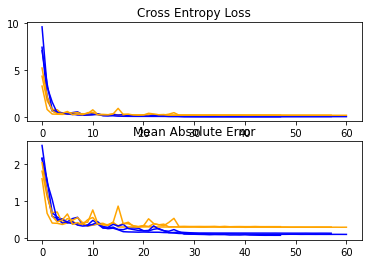

MAE: mean=0.304 std=0.006, n=3


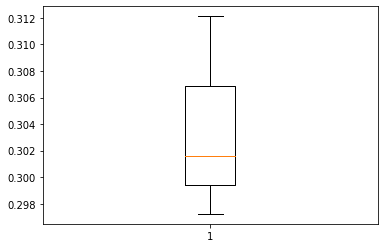

In [16]:
# load dataset
trainX, testX, trainY, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# evaluate model
scores, histories, model = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)

# save model
model.save('model2.h5')

In [17]:
model = load_model('model2.h5')

In [18]:
# Make predictions with the model
y_pred = model.predict(testX)

# Round result
y_pred_rounded = np.round(y_pred)

# Calculate the absolute errors 
errors = abs(y_pred_rounded - testY)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

4/4 [==============================] - 0s 16ms/step
Mean Absolute Error: 2.36 degrees.


2022-12-20 16:49:37.055061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
for i in range(len(y_pred_rounded)):
    print('Predicted: %.3f, Rounded: %.3f, Expected: %.3f' % (y_pred[i], y_pred_rounded[i], y_test[i]))

Predicted: 6.866, Rounded: 7.000, Expected: 7.000
Predicted: 2.905, Rounded: 3.000, Expected: 3.000
Predicted: 2.972, Rounded: 3.000, Expected: 3.000
Predicted: 3.268, Rounded: 3.000, Expected: 3.000
Predicted: 7.192, Rounded: 7.000, Expected: 8.000
Predicted: 3.135, Rounded: 3.000, Expected: 3.000
Predicted: 4.320, Rounded: 4.000, Expected: 4.000
Predicted: 4.117, Rounded: 4.000, Expected: 4.000
Predicted: 2.817, Rounded: 3.000, Expected: 3.000
Predicted: 3.064, Rounded: 3.000, Expected: 3.000
Predicted: 6.747, Rounded: 7.000, Expected: 7.000
Predicted: 8.509, Rounded: 9.000, Expected: 10.000
Predicted: 3.184, Rounded: 3.000, Expected: 3.000
Predicted: 3.836, Rounded: 4.000, Expected: 4.000
Predicted: 6.947, Rounded: 7.000, Expected: 7.000
Predicted: 8.128, Rounded: 8.000, Expected: 8.000
Predicted: 6.653, Rounded: 7.000, Expected: 6.000
Predicted: 3.430, Rounded: 3.000, Expected: 3.000
Predicted: 4.144, Rounded: 4.000, Expected: 4.000
Predicted: 6.729, Rounded: 7.000, Expected: 7.000